Processing apt-usd-max...
Finished processing apt-usd-max.

Processing bnb-usd-max...
Finished processing bnb-usd-max.

Processing btc-usd-max...
Finished processing btc-usd-max.

Processing eth-usd-max...
Finished processing eth-usd-max.

Processing sol-usd-max...
Finished processing sol-usd-max.

Processing sui-usd-max...
Finished processing sui-usd-max.

Processing wld-usd-max...
Finished processing wld-usd-max.

Processing xrp-usd-max...
Finished processing xrp-usd-max.

Processing 1mbabydoge-usd-max...
Finished processing 1mbabydoge-usd-max.



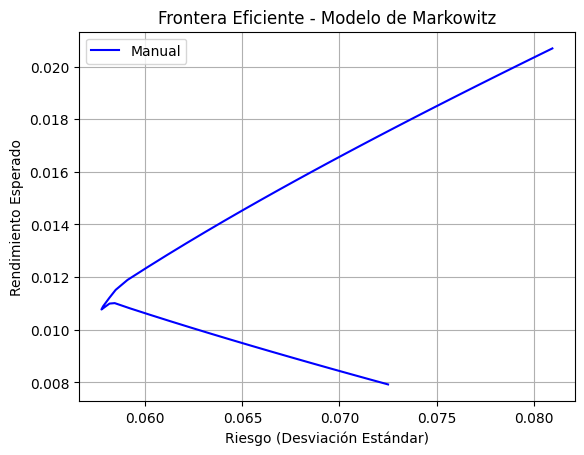

In [7]:
import pandas as pd
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt


def calc_efficiency(file):
    df = pd.read_csv(f'data-8M/{file}.csv', parse_dates=['snapped_at'])
    df = df.sort_values('snapped_at')
    prices = df['price']

    return prices.pct_change().dropna()


# def min_portfolio(r_target, er, sigma, n):
#     P = matrix(sigma)  # Matriz de covarianza (para minimizar X^T Σ X)
#     q = matrix(np.zeros(n))  # Término lineal (0 porque minimizamos varianza)
#     G = matrix(-np.eye(n))  # Restricción X_i >= 0
#     h = matrix(np.zeros(n))
#     A = matrix(np.vstack([er.values, np.ones(n)]))  # Restricciones E(R_p) y suma de pesos
#     b = matrix([r_target, 1.0])  # Rendimiento objetivo y suma de pesos = 1
#     sol = solvers.qp(P, q, G, h, A, b)
#     return np.array(sol['x']).flatten()


def improve_portfolio(R_target, R, Sigma, N):
    A = np.zeros((N + 2, N + 2))
    A[:N, :N] = 2 * Sigma
    A[:N, N] = -R
    A[:N, N + 1] = -np.ones(N)
    A[N, :N] = R.T
    A[N + 1, :N] = np.ones(N)

    b = np.zeros(N + 2)
    b[N] = R_target
    b[N + 1] = 1.0

    try:
        sol = np.linalg.solve(A, b)
        X = sol[:N]
    except np.linalg.LinAlgError:
        return None, None, None

    # Proyectar pesos negativos a cero
    X = np.maximum(X, 0)
    if np.sum(X) > 1e-10:  # Evitar división por cero
        X = X / np.sum(X)
    else:
        return None, None, None

    # Calcular rendimiento y riesgo
    rendimiento = np.dot(X, R)
    riesgo = np.sqrt(np.dot(X, np.dot(Sigma, X)))

    return X, rendimiento, riesgo


if __name__ == '__main__':
    files = ['apt-usd-max', 'bnb-usd-max', 'btc-usd-max', 'eth-usd-max',
             'sol-usd-max', 'sui-usd-max', 'wld-usd-max', 'xrp-usd-max',
             '1mbabydoge-usd-max']
    # files = ['btc-usd-max']

    r = pd.DataFrame()
    for file in files:
        print(f'Processing {file}...')
        efficiency = calc_efficiency(file)
        r[file.split('-')[0]] = efficiency
        print(f'Finished processing {file}.\n')

    r = r.dropna()
    er = r.mean()
    cov_matrix = r.cov().values

    # resp = min_portfolio(0.01, er, cov_matrix, len(files))
    # print(f"resp {resp}")

    N = len(er)  # Número de criptomonedas
    R_min = er.min()
    R_max = er.max()
    R_targets = np.linspace(R_min, R_max, 50)
    riesgos_manual = []
    rendimientos_manual = []
    pesos_manual = []

    for R_target in R_targets:
        X, rendimiento, riesgo = improve_portfolio(R_target, er, cov_matrix, N)
        if X is not None and not np.any(np.isnan(X)):
            rendimientos_manual.append(rendimiento)
            riesgos_manual.append(riesgo)
            pesos_manual.append(X)

    if rendimientos_manual and riesgos_manual:
        plt.plot(riesgos_manual, rendimientos_manual, 'b-', label='Manual')
        plt.xlabel('Riesgo (Desviación Estándar)')
        plt.ylabel('Rendimiento Esperado')
        plt.title('Frontera Eficiente - Modelo de Markowitz')
        plt.legend()
        plt.grid(True)
        plt.show()
